In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../python')
from functions import *
from models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-05-25 13:26:13.199186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-25 13:26:13.217488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.56GiB deviceMemoryBandwidth: 648.29GiB/s
2022-05-25 13:26:13.217809: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-25 13:26:13.219328: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-25 13:26:13.220969: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-25 13:26:13.221283: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-0

In [3]:
stream = "gd1_tail"

In [4]:
df, file = load_file(stream = stream)

### Prepare datasets for training

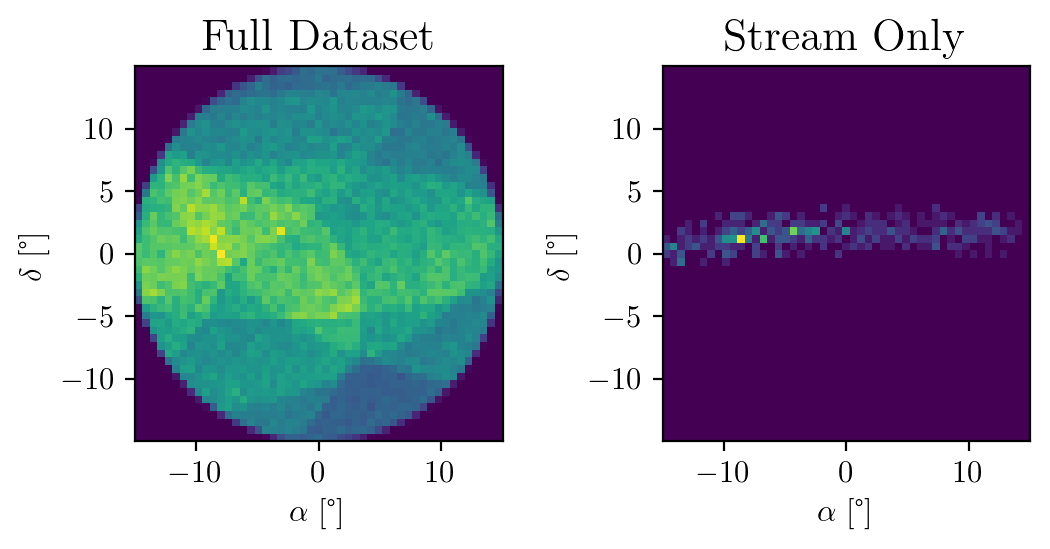

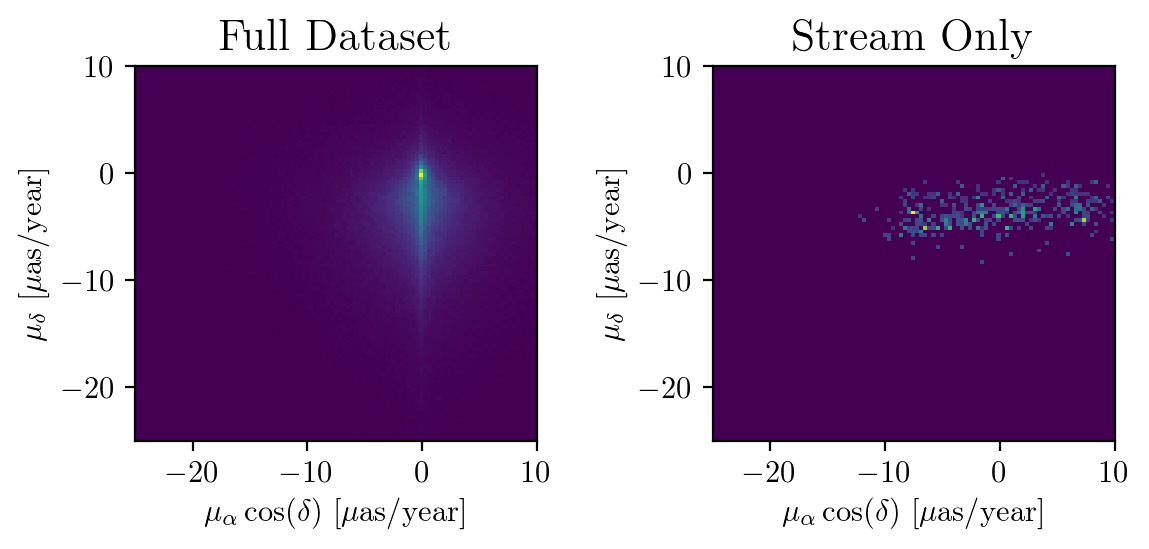

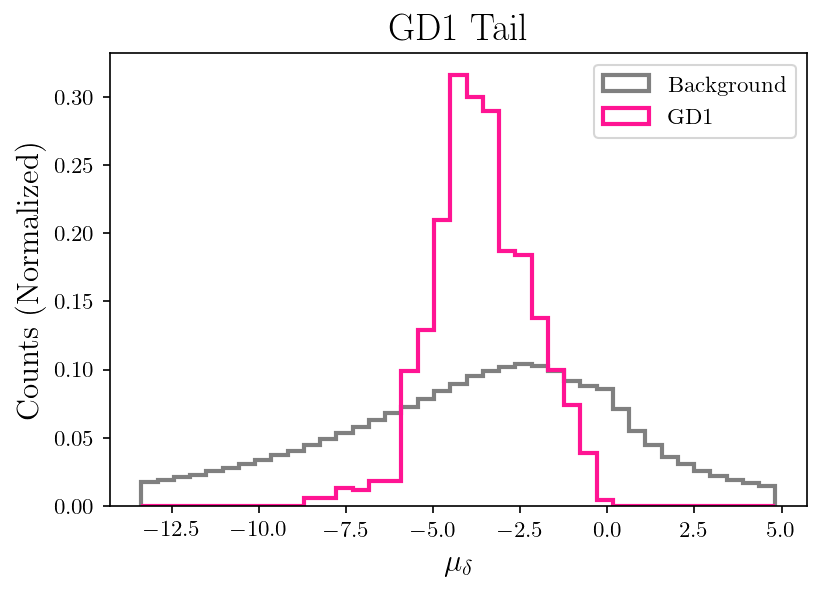

In [5]:
visualize_stream(df)

Sideband region: [-7.0,-3.0]
Signal region: [-6.0,-3.1]
Total counts: SR = 613,810, SB = 181,912


/clusterfs/ml4hep/mpettee/GaiaCWoLa/notebooks/../python/functions.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)


Signal region has 1,565 stream and 612,245 bkg events (0.26%).
Sideband region has 94 stream and 181,818 bkg events (0.05%).
f_sig = 4.9X f_sideband.


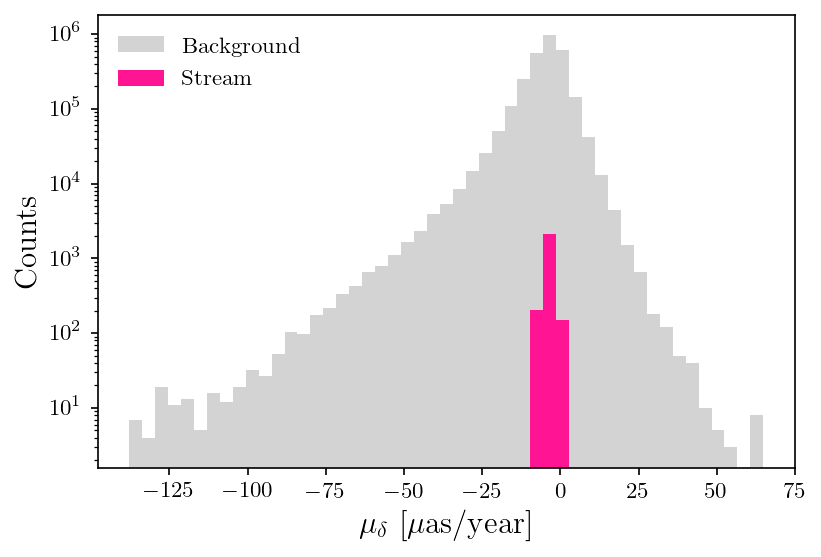

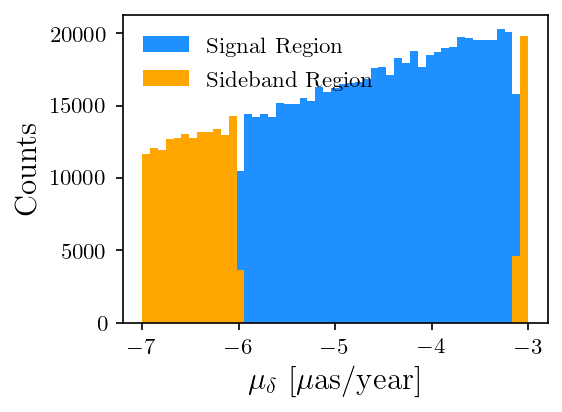

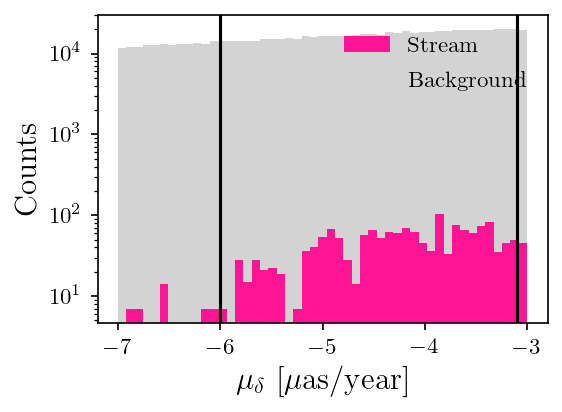

In [6]:
df = signal_sideband(df, stream = stream)

# Train

In [12]:
tf.keras.backend.clear_session()

Not using sample weights
Training on 557,005 events.
Epoch 1/2000
38/38 [==============================] - 0s 10ms/step - loss: 0.5562 - accuracy: 0.7656 - val_loss: 0.5402 - val_accuracy: 0.7725
Epoch 2/2000
38/38 [==============================] - 0s 8ms/step - loss: 0.5406 - accuracy: 0.7712 - val_loss: 0.5363 - val_accuracy: 0.7725
Epoch 3/2000
38/38 [==============================] - 0s 11ms/step - loss: 0.5378 - accuracy: 0.7712 - val_loss: 0.5342 - val_accuracy: 0.7725
Epoch 4/2000
38/38 [==============================] - 0s 9ms/step - loss: 0.5362 - accuracy: 0.7712 - val_loss: 0.5328 - val_accuracy: 0.7725
Epoch 5/2000
38/38 [==============================] - 0s 8ms/step - loss: 0.5354 - accuracy: 0.7712 - val_loss: 0.5330 - val_accuracy: 0.7725
Epoch 6/2000
38/38 [==============================] - 0s 8ms/step - loss: 0.5350 - accuracy: 0.7712 - val_loss: 0.5327 - val_accuracy: 0.7725
Epoch 7/2000
38/38 [==============================] - 0s 8ms/step - loss: 0.5348 - accuracy: 

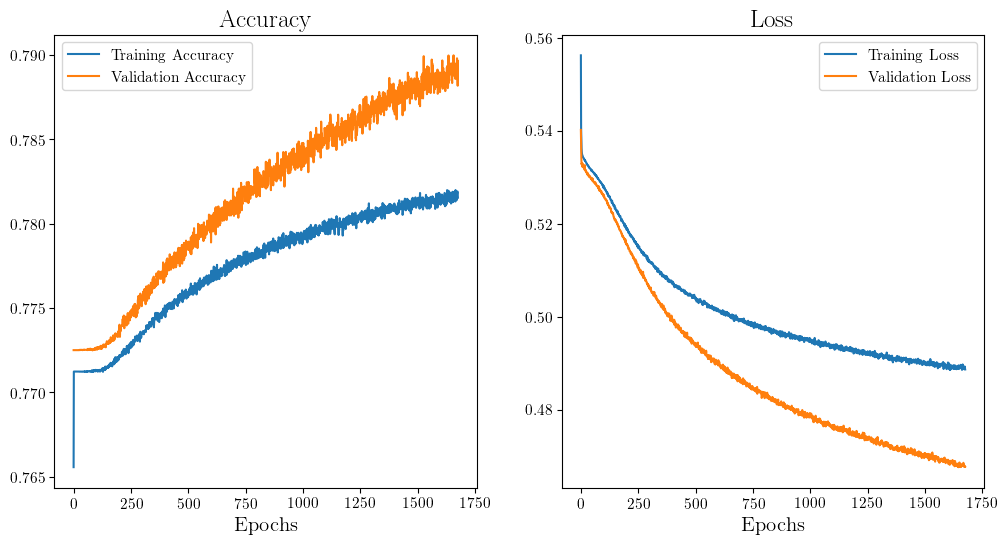

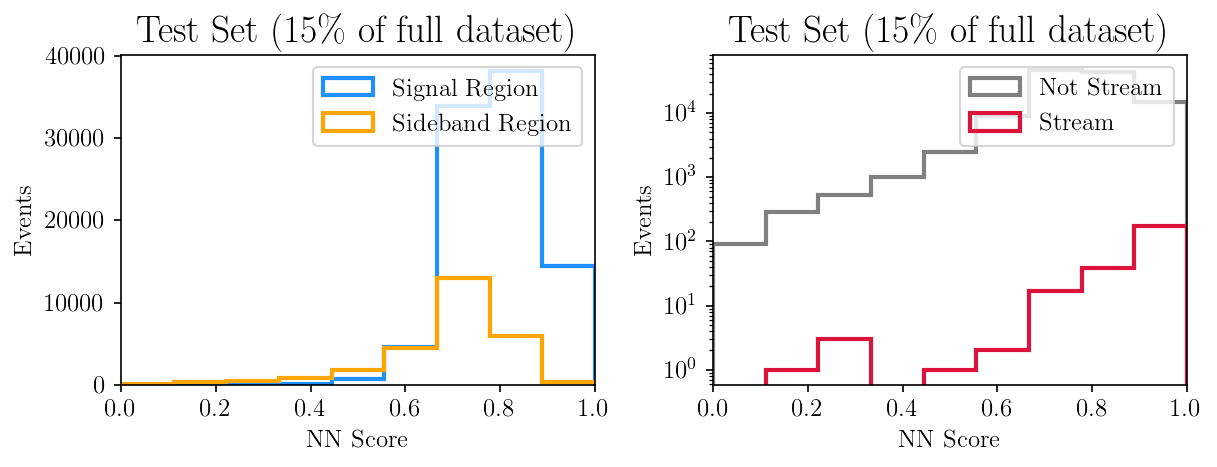

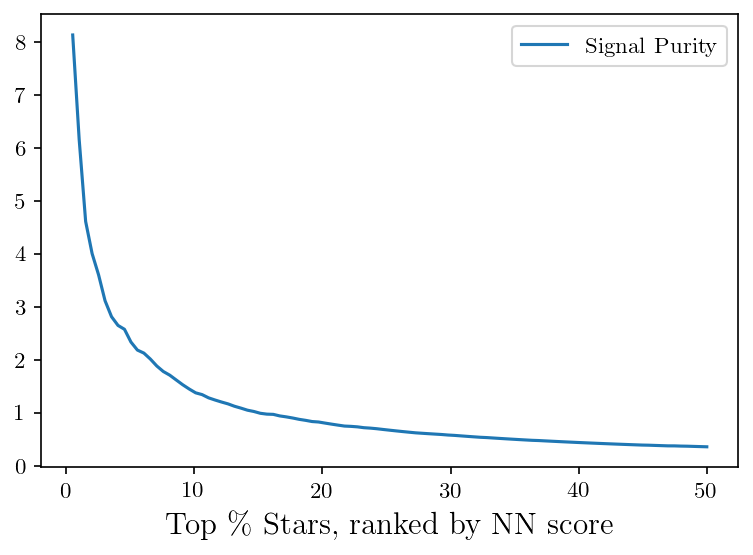

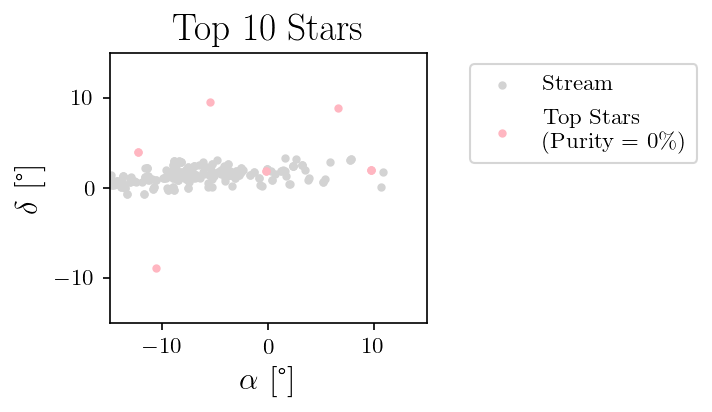

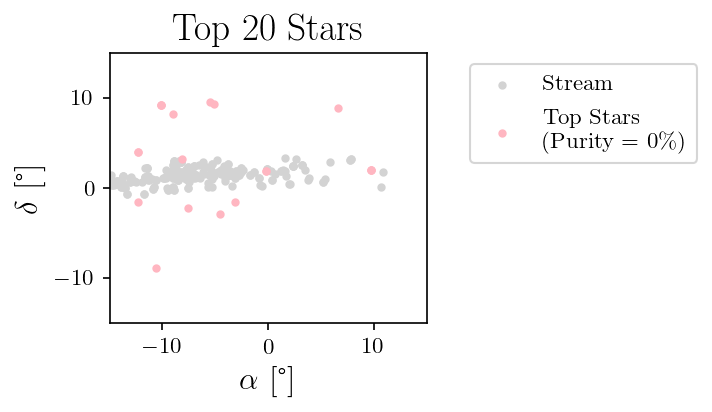

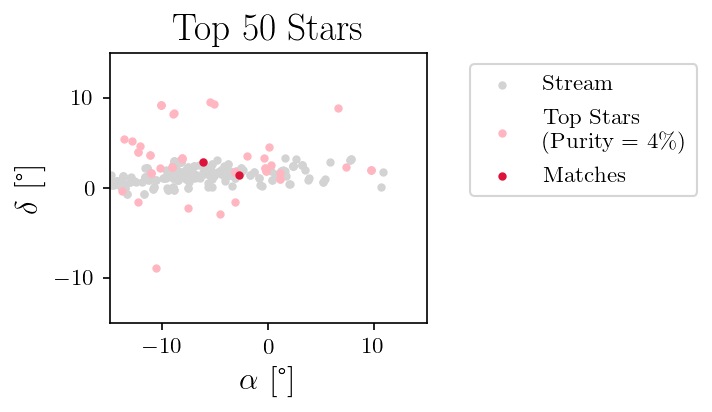

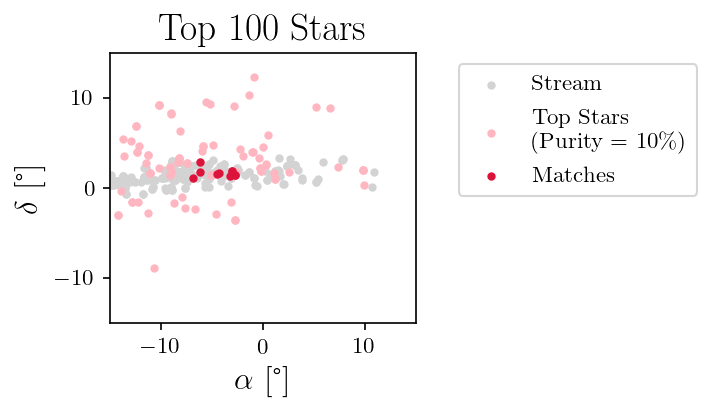

In [13]:
test = train(df, 
      n_folds = 1, 
      best_of_n_loops = 1,
      layer_size = 256, 
      batch_size = 15000, 
      dropout = 0.2, 
      epochs = 2000, 
      l2_reg = 0,
      patience = 30,
      save_folder = "gd1_tail")

In [35]:
test = pd.read_hdf("../trained_models/foundtail_size128_batch10000_epochs2000_again/df_test.h5")

In [36]:
test.α = test.α + 212.7
test.δ = test.δ + 55.2

In [37]:
x = 50 
top_stars = test.sort_values('nn_score',ascending=False)[:x]
stream_stars_in_test_set = test[test.stream == True]
n_perfect_matches = top_stars.stream.value_counts()[True] 

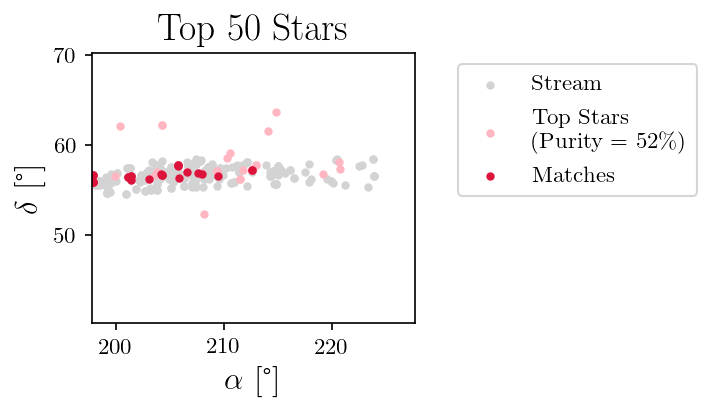

In [39]:
plt.figure(figsize=(5,3), dpi=150, tight_layout=True) 
plt.title('Top {} Stars'.format(x))
plt.scatter(stream_stars_in_test_set.α, stream_stars_in_test_set.δ, marker='.', 
        color = "lightgray",
        label='Stream')
plt.scatter(top_stars.α, top_stars.δ, marker='.', 
        color = "lightpink",
        label="Top Stars\n(Purity = {:.0f}\%)".format(n_perfect_matches/len(top_stars)*100))
if True in top_stars.stream.unique(): 
    plt.scatter(top_stars[top_stars.stream].α, top_stars[top_stars.stream].δ, marker='.', 
            color = "crimson",
            label='Matches')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
plt.xlim(test.α.min(),test.α.max())
plt.ylim(test.δ.min(),test.δ.max())
plt.xlabel(r"$\alpha$ [\textdegree]")
plt.ylabel(r"$\delta$ [\textdegree]");
plt.savefig("top_50_stars_gd1_tail.pdf");